# In-Depth: Decision Trees and Random Forests

# 深入：決策樹和隨機森林

> Previously we have looked in depth at a simple generative classifier (naive Bayes; see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)) and a powerful discriminative classifier (support vector machines; see [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb)).
Here we'll take a look at motivating another powerful algorithm—a non-parametric algorithm called *random forests*.
Random forests are an example of an *ensemble* method, meaning that it relies on aggregating the results of an ensemble of simpler estimators.
The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts: that is, a majority vote among a number of estimators can end up being better than any of the individual estimators doing the voting!

前面我們深入的介紹了簡單的生成分類器（樸素貝葉斯）和強大的決定分類器（支持向量機）。另外一種強大的算法，一個沒有參數被稱為*隨機森林*的算法。隨機森林是一個集成的方法，這意味著它是是在一系列簡單評估器組合的基礎上建立的。令人驚奇的是，這種組合的方法會比獨立的算法應用要強大：即通過多個評估器得到的多數票選舉結果要優於其中任何一個獨立的評估器得到的結果。

對於 Ensemble Learning 跟 Aggregation Models 鮮少有人講兩者的差別在哪。畢竟以中文直翻來看，大多數人很難區別兩者，還甚至有人以為這兩個概念是一樣的！

## Motivating Random Forests: Decision Trees

## 開始學習隨機森林：決策樹 (DT)

> Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification.
For example, if you wanted to build a decision tree to classify an animal you come across while on a hike, you might construct the one shown here:

決策樹（Decision Tree，DT）是一種簡單的機器學習方法，其本質是一堆決策結構以樹形組合起來，葉子節點代表最終的預測值或類別。決策樹本質上是在做若干個決策，以判定輸入的數據對應的類別（分類）或數值（回歸）。每一次決策其實是一次劃分，劃分的方法成為了關鍵，不同的決策樹對應不同的劃分方法。常見的DT有三種：ID3 (1986)、C4.5(1993) 和 CART(1984)

決策樹是用來分類或者標記對象的非常直觀的方法：你只需要簡單的提出一系列設計好的問題，最終達到分類標籤即可。例如，如果希望構建一個用來分類動物的決策樹，你可以構建下面的這棵樹：

![](figures/05.08-decision-tree.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Decision-Tree-Example)

> The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes.
The trick, of course, comes in deciding which questions to ask at each step.
In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features.
Let's now look at an example of this.

這種二元的區分方式使得算法非常高效：在一個構造良好的樹中，每個問題都會使得剩下的可用選項減半，這甚至在分類數量很多情況下也能迅速的得到結果。當然這個效率取決於每一步設計問題的技巧。在決策樹的機器學習實現中，樹中的問題通常都採用沿著軸來分割數據：也就是說，樹中的每個節點會在數據的一個特徵上，根據一個閾值一分為二。

### Creating a decision tree 創建決策樹

> Consider the following two-dimensional data, which has one of four class labels:

考慮下面的二維數據，具有四個分類標籤：

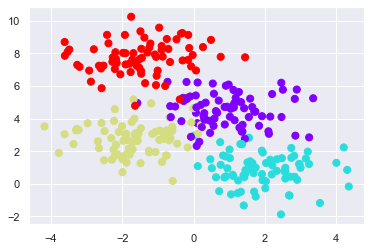

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

> A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it.
This figure presents a visualization of the first four levels of a decision tree classifier for this data:

在這個數據上建立的簡單決策樹會沿著兩個軸來分類數據，每一層的劃分都會按照區域中大多數數據點的分類標籤（多數票）來確定區域的標籤值。下面的圖像展示了頭四層的決策樹進行分類的可視化過程：

![](figures/05.08-decision-tree-levels.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Decision-Tree-Levels)

> Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch.
Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

上圖看到第一層分類後，圖中上部的分支一直保持不變，因此沒有必要再對這個分支進行細分了。除非某個節點已經達到包含同一顏色的目的，否則每一層的不同區域都是再次沿著兩個特徵其中之一對數據進行再次細分。

In [2]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

> Let's write a quick utility function to help us visualize the output of the classifier:

然後我們寫一個工具函數幫助我們展示分類器的數據可視化：

In [3]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # plt
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # result
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

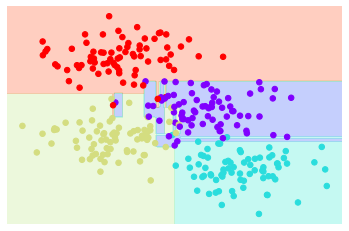

In [4]:
visualize_classifier(DecisionTreeClassifier(), X, y)

> Notice that as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions.
It's clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data.
That is, this decision tree, even at only five levels deep, is clearly over-fitting our data.

隨著深度（樹節點層次）增加，我們會得到一個非常奇怪的分類區域形狀；如上面深度為5時，圖像下部會出現一條很高的狹長紫色區域，處於綠色和藍色區域之間。從直覺上我們就可以知道這是錯誤的，這個結果不是來源自數據的內在分佈特性，而更像是通過數據中個別的樣本或噪音獲得的。也就是說決策樹即使只有5層深也發生了數據的過擬合。

### Decision trees and over-fitting 決策樹和過擬合

> Such over-fitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from.
Another way to see this over-fitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data: It is clear that in some places, the two trees produce consistent results (e.g., in the four corners), while in other places, the two trees give very different classifications (e.g., in the regions between any two clusters).
The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from *both* of these trees, we might come up with a better result!

這種過擬合是決策樹經常出現的問題：很容易就會構建一個深度太大的決策樹，這樣的樹模型會聚焦在數據的特定數據點或噪音之上，而不是數據本身的分佈特性之上。另外一種判斷過擬合的方法是在數據不同子集上的訓練結果，例如，下面兩張圖表示的是在數據集各一半的數據點上訓練得到的兩個不同的模型：很明顯的看到，在一些位置上，兩棵樹都產生了相同的結果（例如四個角附近的位置），但是在其他位置上，兩個模型給出了非常差異的分類結果（例如在兩個分類的交界處）。這些差異一般會出現在分類器確定性較低的位置，因此如果我們同時使用這兩棵樹的特性的話，可以預計得到更好的結果。

![](figures/05.08-decision-tree-overfitting.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

## Ensemble Learning 評估式學習
所謂的Ensemble Learning是將不同的演算法結合起來，最後得出一個效果更好模型的方法。常使用的Ensemble Learning方法有，Averaging、Weighting、Voting、Stacking、Bagging、Boosting。所以說其概念和Aggregation model非常類似，但是 aggregation models 強調的是概念上各種不同的方程式結合，而 Ensemble Learning 強調的是演算法的結合

## Ensembles of Estimators: Random Forests

## 評估器合成：隨機森林

> that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called *bagging*. each of which over-fits the data, and averages the results to find a better classification. An ensemble of randomized decision trees is known as a *random forest*. This type of bagging classification can be done manually using Scikit-Learn's ``BaggingClassifier`` meta-estimator, as shown here:

隨機森林是一個Bagging方法：取出一個樣本加入訓練集，然後再把該樣本放回原始樣本空間，以使下次取樣本依然能取到該樣本。使用這種方式，可以取樣出 T 個包含 m 個樣本的訓練集，並且每個訓練集都不一樣。隨機森林在Bagging的基礎上，進一步在決策樹的訓練過程中引入了一些隨機性：在決定劃分屬性的時候，先隨機選擇一個包含k個屬性的子集，然後再從子集中選擇一個最優屬性進行劃分，這也是隨機的內涵，隨機森林簡單、容易實現、表現良好。

多個過擬合的評估器可以被合併來減少過擬合，被稱為*裝袋(bagging)*，是一種團體學習。裝袋(bagging)將評估器組裝（類似塞到袋子裡）起來，其中的每個評估器都會產生過擬合，然後對結果求平均來得到一個更好的分類。對隨機決策樹的組裝被稱為*隨機森林*。這種類型的裝袋分類可以通過Scikit-Learn的`BaggingClassifier`元評估器來手動實現：

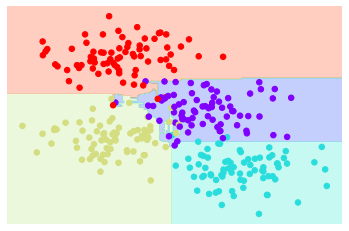

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

> In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.
For example, when determining which feature to split on, the randomized tree might select from among the top several features.
You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

在上例中，我們通過在數據集的隨機80%的數據點上擬合出100個模型。在實踐中，決策樹可以通過注入更多的隨機性來選擇子數據集以達到更好的效果：這個方法中所有的數據在每次擬合過程中都會產生貢獻，但是擬合的結果仍然具有期望的隨機性。例如當決定哪個特徵來劃分數據集時，隨機決策樹可以從前面幾個特徵中進行不同的選擇。你可以在[Scikit-Learn在線文檔](http://scikit-learn.org/stable/modules/ensemble.html#forest)中督導更多這些隨機策略的技術細節。

> In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

在Scikit-Learn中，上述的隨機決策樹的優化組合算法被實現在`RandomForestClassifier`評估器中，它能全自動地處理所有的隨機情況。你只需要設置評估器的個數，它能迅速的（根據需要進行並行計算）擬合整個森林：可以看到，通過在100個隨機選擇的模型上進行平均，我們能夠得到一個更加符合我們對數據集分佈的直覺模型。

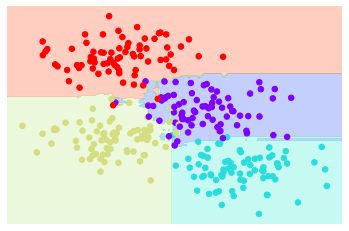

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

### Example RandomForests

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

data=pd.read_csv("input/ml-product.csv")
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19.0,19000.0,0
1,15810944,Male,35.0,20000.0,0
2,15668575,Female,26.0,43000.0,0
3,15603246,Female,27.0,57000.0,0
4,15804002,Male,19.0,76000.0,0


In [9]:
# GaussianNB 擬和 fit
from sklearn.preprocessing import StandardScaler

X=data.iloc[:,[2,3]].values
Y=data.iloc[:,4].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y,test_size=0.2)

model=RandomForestClassifier(max_leaf_nodes=10)
model.fit(X_train,Y_train)

RandomForestClassifier(max_leaf_nodes=10)

In [10]:
# 進行預測標籤
y_predicted=model.predict(X_test)
y_predicted

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1])

<AxesSubplot:>

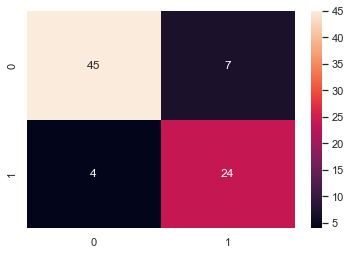

In [11]:
matrix=confusion_matrix(Y_test,y_predicted)
import seaborn as sns
sns.heatmap(matrix,annot=True)

## Random Forest Regression

## 隨機森林回歸

> In the previous section we considered random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is the ``RandomForestRegressor``, and the syntax is very similar to what we saw earlier.

在前面內容中我們介紹了隨機森林應用在分類場景下的方法。隨機森林也能在回歸場景中使用（即非離散的分類而是連續的分類）。實現這個場景的評估器是`RandomForestRegressor`，它的語法和前面看到的分類語法很相似。

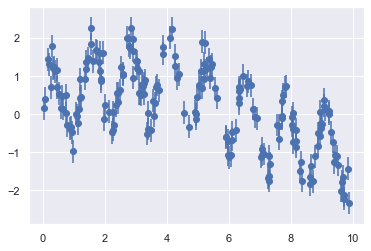

In [12]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

> Using the random forest regressor, we can find the best fit curve as follows:

使用隨機森林回歸，我們能獲得下面的最佳擬合曲線：

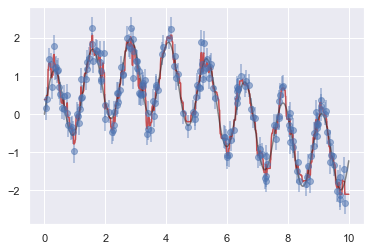

In [13]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

> Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.
As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

上面真實的數據使用灰色光滑的曲線展示，而隨機森林模型使用紅色鋸齒曲線展示。可以看到無參數的隨機森林模型可以足夠靈活的擬合多周期數據，甚至不需要指定任何多周期模型。

## Example: Random Forest for Classifying Digits

## 例子：使用隨機森林分類手寫數字

> Earlier we took a quick look at the hand-written digits data (see [Introducing Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb)).
Let's use that again here to see how the random forest classifier can be used in this context.

前面我們快速的介紹了一下手寫數字數據（參見[Scikit-Learn簡介](05.02-Introducing-Scikit-Learn.ipynb)）。下面我們來看看隨機森林分類器在這個場景下的應用。

In [14]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

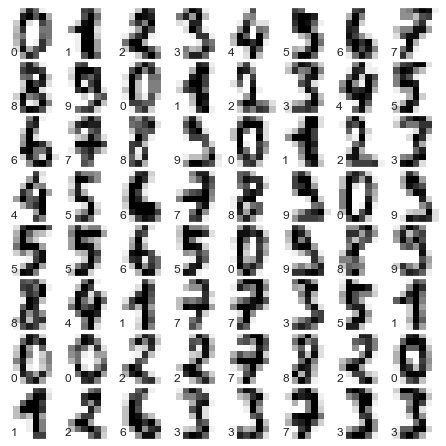

In [15]:
# 设置图表
fig = plt.figure(figsize=(6, 6))  # 图表尺寸
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# 绘制数字，每个数字都是8x8大小
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # 添加数字的标签
    ax.text(0, 7, str(digits.target[i]))

> We can quickly classify the digits using a random forest as follows:

然後我們使用隨機森林來分類這些數字：

In [16]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [17]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.95      0.97        44
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



> And for good measure, plot the confusion matrix:

為了更清晰，還可以繪製混淆矩陣：

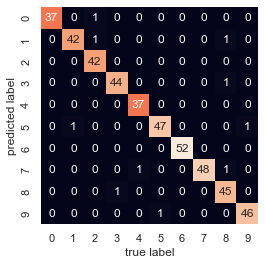

In [18]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

> We find that a simple, untuned random forest results in a very accurate classification of the digits data.

從這個例子我們發現，一個簡單未經過優化的隨機森林算法，就能在手寫數字分類上得到非常精確的分類結果。

## Summary of Random Forests 隨機森林總結

> This section contained a brief introduction to the concept of *ensemble estimators*, and in particular the random forest – an ensemble of randomized decision trees.
Random forests are a powerful method with several advantages:

本節中介紹了*組合評估器*的概念，進一步介紹了隨機森林，一個隨機化決策樹的團隊算法。隨機森林由於下述優點使其成為很強大的一個方法：

- 訓練和預測都非常快，因為其基礎決策樹計算非常簡單。並且所有的任務都能直接地並行化，因為每一棵獨立的樹都是完全無關的。
- 多棵決策樹都可以進行概率分類：區域內的大多數票給出了概率分佈的估計值（使用Scikit-Learn的`predict_proba()`實現）。
- 無參數的模型非常靈活，可以在其他評估器欠擬合的情況下工作得很良好。

> A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.

隨機森林最主要的缺點在於結果不容易解釋：也即是說，如果你試圖從分類模型中提取深層次的*含義*的話，隨機森林可能不是最好的選擇。

# Aggregation Models
# 聚類模型

Aggregation Models 是指將不同的特徵和模型結合起來，得到一個更好的模型。而aggregation models可以用式子表示：對於Aggregation Models來說，透過不同的模型結合，可以防止Overfitting的問題，今天如果我們中間產生10個models，其中一個發生overfitting的情況，但其他9個泛化程度剛好，我們就可以透過aggregation的方式，結合10個models，所以原本可能會產生overfitting的model，經過結合後就正常了。從集合的方法上也可以進一步細分三種 Aggregation Type 模型結合類型：
- Uniform Aggregation Type：以最公平的方式，一人一票，決定要不要，所以每個子模型的 c_t=1
- Non-uniform Aggregation Type：給比較有經驗的人比較多票，最後再決定要不要，所以每個子模型的 c_t 為常數，但可能都不一樣。
- Conditional Aggregation Type：依據每個人不一樣的專長，依照不同情況給不同票數，所以每個子模型的 c_t 為一方程式

- T 代表子模型的數量。
- c_t 代表特定方程式，可以為常數、或是方程式。
- G_t 代表子模型的方程式，其一樣可以為常數，但大部分都是方程式。

![](figures/boost.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

Aggregation Models 是先Train出一個獨立的 Predictive Features，然後在綜合它們，集合的處理可以分成兩大類，

#### Blending Models：集合的動作是發生在訓練好的 Predictive Feature 之後。當資料產生各種子模型後，最後再把它結合起來。

1. Averaging(Uniform): 當模型建立好後，以權重為1把每個模型結合起來。
2. Weighting(Non-uniform): 當模型建立好後，以不同的權重把每個模型結合起來。
3. Stacking (Conditional): 當模型建立好後，以特定方程式把每個模型結合起來。


#### Learning Models：集合的動作和訓練同步進行。一邊產生子模型一邊結合。

1. Bagging (Uniform): 一開始先把資料均勻分成若干等分，產生數個模型之後，以權重1把每個模型結合起來。
2. Boosting(Non-uniform):一開始先把資料均勻分成若干等分，依序產生數個模型的過程中，當前產生的模型會被上一個模型影響。
3. Decision(Conditional):依據條件式區分成若干子集判斷區分，直到不能分下去為止就產生子模型，最後以方程式將其合併起來。使用Decision Tree結合其他方法再進一步的產生Random Forest、AdaBoost Decision Tree和GradientBoost Decision Tree。

![](figures/Aggregation.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

## Learning Models 的 Boosting 方法

在訓練過程所產生的 Predictive Feature 朝著改善 Model 的方向前進就叫做Boost。也就是試著在Training的過程中改善 Model，試圖讓 Model整體更完善，更能發揮 Aggregation Models 中截長補短中的「補短」的效果，通常又可以再分成負責處理 Classification 的 AdaBoost 和處理 Regression 的 GradientBoost。

實際上我們應該怎麼做才能實踐Boost呢？其實方法的道理早就透漏在上一回中的Bagging和Decision Tree裡頭了，不管是Bagging和Decision Tree 都是使用「變換Data」來做到變異度，在這個方法下Model的架構可以本身是不變的，而今天我們要講的Boost也同樣的利用「變換Data」來做到變異度，但不同的是Boost的過程中「變換Data」這件事是有目標性的。Boost方法在「變換Data」時會試著去凸顯原先做錯的Data，而降低原本已經做對的Data，藉由這樣的方法訓練出來的gt可以補齊前面的不足，所以Boost的過程將會使得Model漸漸的完善，這就是Boost的主要精髓。

### AdaBoost (Adaptive Boost) for Classification

在分類問題中我們怎麼做到「凸顯原先做錯的Data」？簡單的想法是這樣的，我們可以減少原本已經是正確分類的Data的數量，然後增加原本錯誤分類的Data的數量，增減Data的數量其實是等效於改變每筆Data的權重，假如我們給每筆資料權重，要做的事是拉低正確分類Data的權重，而且拉高錯誤分類Data的權重。

那我們應該要提升權重或降低權重到什麼程度才是OK的呢？換個方式思考，我們為什麼要去調整權重？目的其實是要去凸顯原先做錯的部分，降低原本做對的部分，也就是想藉由調整每筆Data的多寡或權重來做到「弭平原先的預測性」，最好可以讓原本的預測方法看起來是隨機分布，也就是「錯誤率＝正確率」，讓它像是擲銅板一樣，沒有什麼預測能力。

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv("input/ml-boost.csv")
data.head()
# data.keys()
# data.describe()
# data.shape

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [24]:
from sklearn.model_selection import train_test_split
X = data.iloc[:, 2:-1]
y = data.iloc[:,1]

#converting value of B and M into 1 and 0
y = [1 if i=='M' else 0 for i in y]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
#initalizing the Adaboost model
from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=0)
classifier.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=0)

<AxesSubplot:>

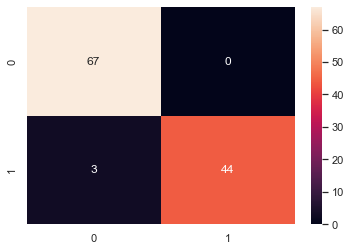

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_predict = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot= True)

In [27]:
#Accuracy and Classification report
print(accuracy_score(y_test,y_predict))
print(classification_report(y_test, y_predict))

0.9736842105263158
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        67
           1       1.00      0.94      0.97        47

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



![title](https://www.ycc.idv.tw/media/MachineLearningTechniques/MachineLearningTechniques.012.jpeg)

### Gradient Boost for Regression

剛剛我們講了AdaBoost，是個很神奇的方法，當我們做錯了，沒關係！從哪裡跌倒就從哪裡站起來，利用這種精神我們就可以做到Boost的效果，但美中不足的是上面的方法只能用在「分類問題」上，那如果我也想在「Regression問題」也做到Boost呢？這就是接下來要講的GradientBoost的方法。

![title](https://www.ycc.idv.tw/media/MachineLearningTechniques/MachineLearningTechniques.013.jpeg)

## AdaBoosted Decision Tree和Gradient Boosted Decision Tree (GBDT)

## 梯度提升決策樹 (GBDT)

>Gradient boosting is a machine learning technique used in regression and classification tasks, among others. It gives a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees. When a decision tree is the weak learner, the resulting algorithm is called gradient-boosted trees; A gradient-boosted trees model is built in a stage-wise fashion as in other boosting methods, but it generalizes the other methods by allowing optimization of an arbitrary differentiable loss function.


梯度提升是一種用於回歸、分類的機器學習技術。以弱預測模型(決策樹)集合的形式給出了一個預測模型，當他為弱學習器時(weak learner) 生成的算法則稱為梯度提升樹。它通常優於隨機森林。梯度提升樹模型以階段方式構建，但它通過允許優化任意可微損失函數來推廣其他方法。梯度提升決策樹，可以分兩部分理解他，「提升決策樹和梯度提升」。BDT的本質：森林中的每棵樹是有序的，第二顆樹學習的目標是上一課樹的殘差，整個算法的輸出是每棵樹結果的和。

GBDT的思想可以用一個通俗的例子解釋，我們要預測一個人的年齡，假如訓練數據中A的年齡是30歲，
- 第一棵樹，我們首先用 20 歲去擬合，發現殘差有10歲， (30-20 = 10)
- 第二棵樹，這時我們用 6 歲去擬合剩下的損失，發現差距還有4歲殘差 (10-6 = 4)
- 第三顆樹，我們用 3 歲擬合剩下的差距，差距就只有 1 歲了(4-3=1)，直到算法終止
- 三棵樹加起來為29 (20+6+3)歲，距離30最近。

GBDT最核心的兩部分，
- Boosting提昇說明每棵樹之間是有關係有序的
- Gradient梯度指明了提升的方向與大小。

最後說下GBDT的正則化，主要有以下措施：
- 1.Early Stopping 訓練輪數，本質是在某項指標達標後就停止訓練
- 2.Shrinkage 學習率，將每課樹的效果進行縮減，比如說將每棵樹的結果乘以0.1，也就是降低單棵樹的決策權重
- 3.Subsampling，無放回抽樣，具體含義是每輪訓練隨機使用部分訓練樣本，其實這裡是藉鑑了隨機森林的思想


![title](https://www.ycc.idv.tw/media/MachineLearningTechniques/MachineLearningTechniques.014.jpeg)

## GradientBoosting 
## 梯度提升演算 (GBoost)

In [30]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv("input/ml-boost.csv")
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [31]:
from sklearn.model_selection import train_test_split

X = data.iloc[:, 2:-1]
y = data.iloc[:,1]

#converting value of B and M into 1 and 0
y = [1 if i=='M' else 0 for i in y]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #split into 80 % and 20% dataset

In [32]:
from sklearn.ensemble import GradientBoostingClassifier 
classifier = GradientBoostingClassifier (min_samples_split=2,max_depth=3,max_features=None,learning_rate=0.01 , n_estimators = 50,random_state=0)
classifier.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=50, random_state=0)

<AxesSubplot:>

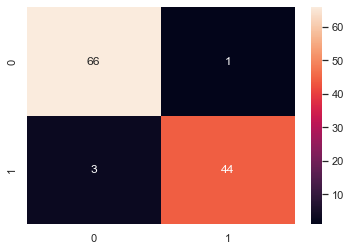

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_predict = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot= True)

In [34]:
#Accuracy and Classification report
print(accuracy_score(y_test,y_predict))
print(classification_report(y_test, y_predict))

0.9649122807017544
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        67
           1       0.98      0.94      0.96        47

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



## eXtreme Gradient Boosting
## 極限梯度提升 (XGBoost)

>It was initially developed by Tianqi Chen and was described by Chen and Carlos Guestrin in their 2016 paper titled “XGBoost: A Scalable Tree Boosting System.”It is designed to be both computationally efficient (e.g. fast to execute) and highly effective, perhaps more effective than other open-source implementations.The name xgboost, though, actually refers to the engineering goal to push the limit of computations resources for boosted tree algorithms. Which is the reason why many people use xgboost.— Tianqi Chen, in answer to the question “What is the difference between the R gbm (gradient boosting machine) and xgboost (extreme gradient boosting)?” on Quora. The two main reasons to use XGBoost are execution speed and model performance.

它最初由 Tianqi Chen 開發，並由 Chen 和 Carlos Guestrin 在他們 2016 年題為“XGBoost: A Scalable Tree Boosting System”的論文中進行了描述。它的設計既具有計算效率（例如，執行速度快），又具有很高的效率。xgboost 這個名字實際上指的是推動提升樹算法的計算資源限制。 使用 XGBoost 的兩個主要原因是執行速度和模型性能。

In [39]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv("input/ml-boost.csv")
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [40]:
from sklearn.model_selection import train_test_split

X = data.iloc[:, 2:-1]
y = data.iloc[:,1]

#converting value of B and M into 1 and 0
y = [1 if i=='M' else 0 for i in y]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [41]:
from sklearn.ensemble import GradientBoostingClassifier 
classifier = GradientBoostingClassifier (min_samples_split=2,max_depth=3,max_features=None,learning_rate=0.01 , n_estimators = 50,random_state=0)
classifier.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=50, random_state=0)

<AxesSubplot:>

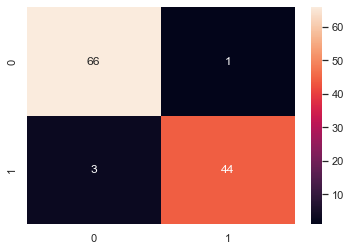

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_predict = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot= True)

In [43]:
#Accuracy and Classification report
print(accuracy_score(y_test,y_predict))
print(classification_report(y_test, y_predict))

0.9649122807017544
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        67
           1       0.98      0.94      0.96        47

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



<!--NAVIGATION-->
< [深入：支持向量机](05.07-Support-Vector-Machines.ipynb) | [目录](Index.ipynb) | [深入：主成分分析](05.09-Principal-Component-Analysis.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/05.08-Random-Forests.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


### Example decision tree

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split

data=pd.read_csv("input/ml-Product.csv")
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19.0,19000.0,0
1,15810944,Male,35.0,20000.0,0
2,15668575,Female,26.0,43000.0,0
3,15603246,Female,27.0,57000.0,0
4,15804002,Male,19.0,76000.0,0


In [45]:
X=data.iloc[:,[2,3]].values
Y=data.iloc[:,4].values

[Text(0.45454545454545453, 0.9166666666666666, 'X[0] <= 0.463\ngini = 0.457\nsamples = 320\nvalue = [207, 113]'),
 Text(0.18181818181818182, 0.75, 'X[1] <= 0.58\ngini = 0.272\nsamples = 228\nvalue = [191, 37]'),
 Text(0.09090909090909091, 0.5833333333333334, 'gini = 0.07\nsamples = 193\nvalue = [186, 7]'),
 Text(0.2727272727272727, 0.5833333333333334, 'X[0] <= -1.065\ngini = 0.245\nsamples = 35\nvalue = [5, 30]'),
 Text(0.18181818181818182, 0.4166666666666667, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.36363636363636365, 0.4166666666666667, 'X[1] <= 1.402\ngini = 0.208\nsamples = 34\nvalue = [4, 30]'),
 Text(0.2727272727272727, 0.25, 'X[1] <= 1.109\ngini = 0.375\nsamples = 16\nvalue = [4, 12]'),
 Text(0.18181818181818182, 0.08333333333333333, 'gini = 0.0\nsamples = 10\nvalue = [0, 10]'),
 Text(0.36363636363636365, 0.08333333333333333, 'gini = 0.444\nsamples = 6\nvalue = [4, 2]'),
 Text(0.45454545454545453, 0.25, 'gini = 0.0\nsamples = 18\nvalue = [0, 18]'),
 Text(0.72727272727

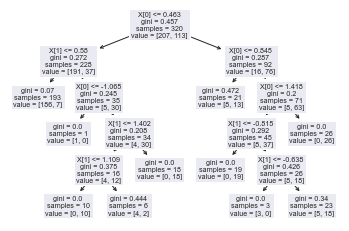

In [46]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

X_train,X_test,Y_train,Y_test=train_test_split(X_scaled,Y,test_size=0.2)
model=tree.DecisionTreeClassifier(max_leaf_nodes=10)  #沿著兩個特徵其中之一對數據進行再次細分
tree.plot_tree(model.fit(X_train,Y_train))

<AxesSubplot:>

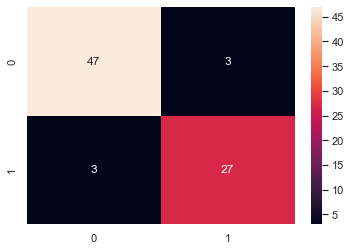

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_predicted=model.predict(X_test)
matrix=confusion_matrix(Y_test,y_predicted)
sns.heatmap(matrix,annot=True)

## Example

# Random Forest Project - Solutions

For this project, we will be exploring for public data at www.lendingclub.com. The Lending Club connects people who need money (borrowers) with people who have money (investors). Hopefully, as an investor, you might want to invest in people who present a high repayment profile to you. We will try to create a model to help predict this.

The lending club had [a very interesting year in 2016] (https://en.wikipedia.org/wiki/Lending_Club#2016), let's review some of its data and keep the context in mind. This data belongs to before it went public.

We will use loan data for the period 2007-2010 and try to classify and estimate whether the borrower has paid back the loan in full.

Here are what the columns represent:
* credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
* purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
* int.rate: Proportionally the interest rate of the loan (an 11% rate will be stored as 0.11). Higher interest rates are assigned to borrowers who are decided by LendingClub.com to be more risky.
* installment: Monthly installments to be received by the borrower if the loan is financed.
* log.annual.inc: The natural log of the self-reported annual income of the borrower.
* dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
* fico: The FICO credit score of the borrower.
* days.with.cr.line: The number of days the borrower has had a credit line.
* revol.bal: Borrower's revolving balance (amount outstanding at the end of the credit card billing cycle).
* revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
* inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
* delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
* pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

loans = pd.read_csv('input/ml-loan.csv')
loans.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


## 1.Exploratory Data Analysis

Let's do some data visualization! We'll use seaborn and pandas built-in plotting capabilities, but feel free to use whatever library you want. Don't worry about the colors matching, just worry about getting the main idea of the plot.

**Create a histogram of two FICO distributions on top of each other, one for each credit.policy outcome.**

*Note: This is pretty tricky, feel free to reference the solutions. You'll probably need one line of code for each histogram, I also recommend just using pandas built in .hist()*

Text(0.5, 0, 'FICO')

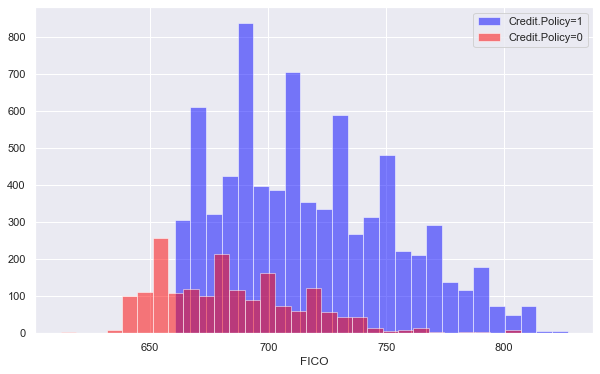

In [50]:
plt.figure(figsize=(10,6))
loans[loans['credit.policy']==1]['fico'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Credit.Policy=1')
loans[loans['credit.policy']==0]['fico'].hist(alpha=0.5,color='red',
                                              bins=30,label='Credit.Policy=0')
plt.legend()
plt.xlabel('FICO')

**Create a similar figure, except this time select by the not.fully.paid column.**

Text(0.5, 0, 'FICO')

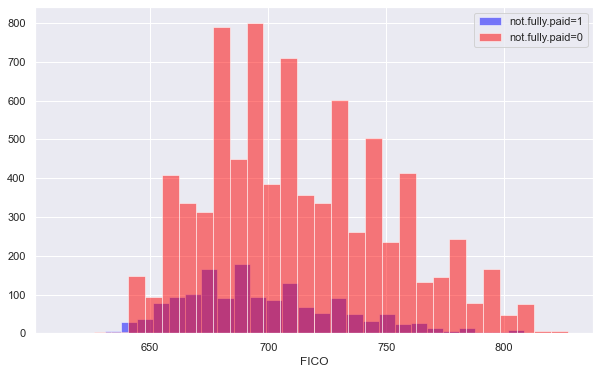

In [51]:
plt.figure(figsize=(10,6))
loans[loans['not.fully.paid']==1]['fico'].hist(alpha=0.5,color='blue',
                                              bins=30,label='not.fully.paid=1')
loans[loans['not.fully.paid']==0]['fico'].hist(alpha=0.5,color='red',
                                              bins=30,label='not.fully.paid=0')
plt.legend()
plt.xlabel('FICO')

**Create a countplot using seaborn showing the counts of loans by purpose, with the color hue defined by not.fully.paid.**

<AxesSubplot:xlabel='purpose', ylabel='count'>

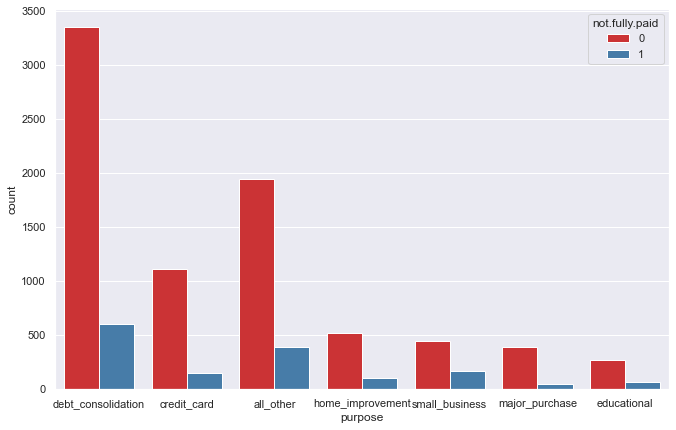

In [52]:
plt.figure(figsize=(11,7))
sns.countplot(x='purpose',hue='not.fully.paid',data=loans,palette='Set1')

**Let's see the trend between FICO score and interest rate. Recreate the following jointplot.**

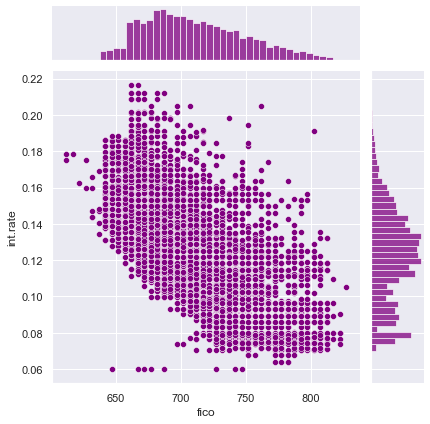

In [53]:
sns.jointplot(x='fico',y='int.rate',data=loans,color='purple')

**Create the following lmplots to see if the trend differed between not.fully.paid and credit.policy. Check the documentation for lmplot() if you can't figure out how to separate it into columns.**

<Figure size 792x504 with 0 Axes>

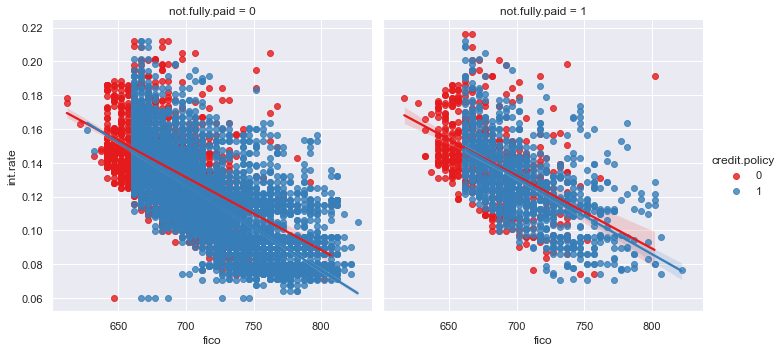

In [54]:
plt.figure(figsize=(11,7))
sns.lmplot(y='int.rate',x='fico',data=loans,hue='credit.policy',
           col='not.fully.paid',palette='Set1')

# Episode 4: Setting up the Data

Let's get ready to set up our data for our Random Forest Classification Model!

## Categorical Features

Notice that the **purpose** column as categorical

That means we need to transform them using dummy variables so sklearn will be able to understand them. Let's do this in one clean step using pd.get_dummies.

Let's show you a way of dealing with these columns that can be expanded to multiple categorical features if necessary.

**Create a list of 1 element containing the string 'purpose'. Call this list cat_feats.**

In [55]:
cat_feats = ['purpose']

**Now use pd.get_dummies(loans,columns=cat_feats,drop_first=True) to create a fixed larger dataframe that has new feature columns with dummy variables. Set this dataframe as final_data.**

In [56]:
final_data = pd.get_dummies(loans,columns=cat_feats,drop_first=True)
final_data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


## Episode 5: Train Test Split

Now its time to split our data into a training set and a testing set!

**Use sklearn to split your data into a training set and a testing set as we've done in the past.**

In [57]:
from sklearn.model_selection import train_test_split

X = final_data.drop('not.fully.paid',axis=1)
y = final_data['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

## Episode 6: Training a Decision Tree Model

Let's start by training a single decision tree first!

**Import DecisionTreeClassifier**

In [58]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

##  Predictions and Evaluation of Decision Tree
**Create predictions from the test set and create a classification report and a confusion matrix.**

In [59]:
predictions = dtree.predict(X_test)

In [60]:
from sklearn.metrics import classification_report,confusion_matrix

In [61]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      2431
           1       0.20      0.25      0.22       443

    accuracy                           0.73      2874
   macro avg       0.53      0.53      0.53      2874
weighted avg       0.76      0.73      0.74      2874



In [62]:
print(confusion_matrix(y_test,predictions))

[[1992  439]
 [ 334  109]]


## Episode 7: Training the Random Forest model

Now its time to train our model!

**Create an instance of the RandomForestClassifier class and fit it to our training data from the previous step.**

In [63]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=600)

## Predictions and Evaluation

Let's predict off the y_test values and evaluate our model.

**Predict the class of not.fully.paid for the X_test data.**

In [64]:
predictions = rfc.predict(X_test)

**Now create a classification report from the results. Do you get anything strange or some sort of warning?**

In [65]:
from sklearn.metrics import classification_report,confusion_matrix

In [66]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2431
           1       0.50      0.02      0.03       443

    accuracy                           0.85      2874
   macro avg       0.67      0.51      0.47      2874
weighted avg       0.79      0.85      0.78      2874



**Show the Confusion Matrix for the predictions.**

In [67]:
print(confusion_matrix(y_test,predictions))

[[2424    7]
 [ 436    7]]


**What performed better the random forest or the decision tree?**

In [68]:
# Depends what metric you are trying to optimize for. 
# Notice the recall for each class for the models.
# Neither did very well, more feature engineering is needed.

## Example - Decision Tree Implementation

In [69]:
from matplotlib import pyplot as plt 
from sklearn.datasets import load_iris
import pandas as pd 
import numpy as np
import seaborn as sns

data = load_iris()
df = pd.DataFrame(data = np.c_[data['data'], data['target']],
                  columns= data['feature_names'] + ['target'])

In [70]:
# Checking which classes to predict
# 0: setoas, 1: versicolor, 2: virginica
print("Classes: ", data.target_names)
X = data.data
y = data.target

# Displaying data (first 5 data points)
print(df.head())

# Checking columns, number of samples, and printing first few rows
print(df.columns)
print("Number of samples: ", X.shape[0])
print(X[:4])

# Checking variance
print(df.var())

Classes:  ['setosa' 'versicolor' 'virginica']
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')
Number of samples:  150
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]]
sepal length (cm)    0.685694
sepal width (cm)     0.189979
petal length (cm)    3.116278
petal width (cm)     0.581006
target               0.671141
dtype: float64


In [71]:
# Getting correlations between all of the columns
df.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.000000,-0.117570,0.871754,0.817941,0.782561
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126,-0.426658
petal length (cm),0.871754,-0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,-0.366126,0.962865,1.000000,0.956547
target,0.782561,-0.426658,0.949035,0.956547,1.000000


<AxesSubplot:>

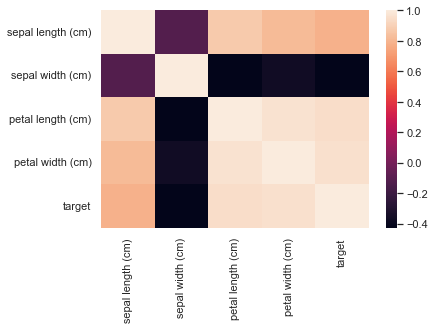

In [72]:
# Heatmap of correlations
sns.heatmap(df.corr())

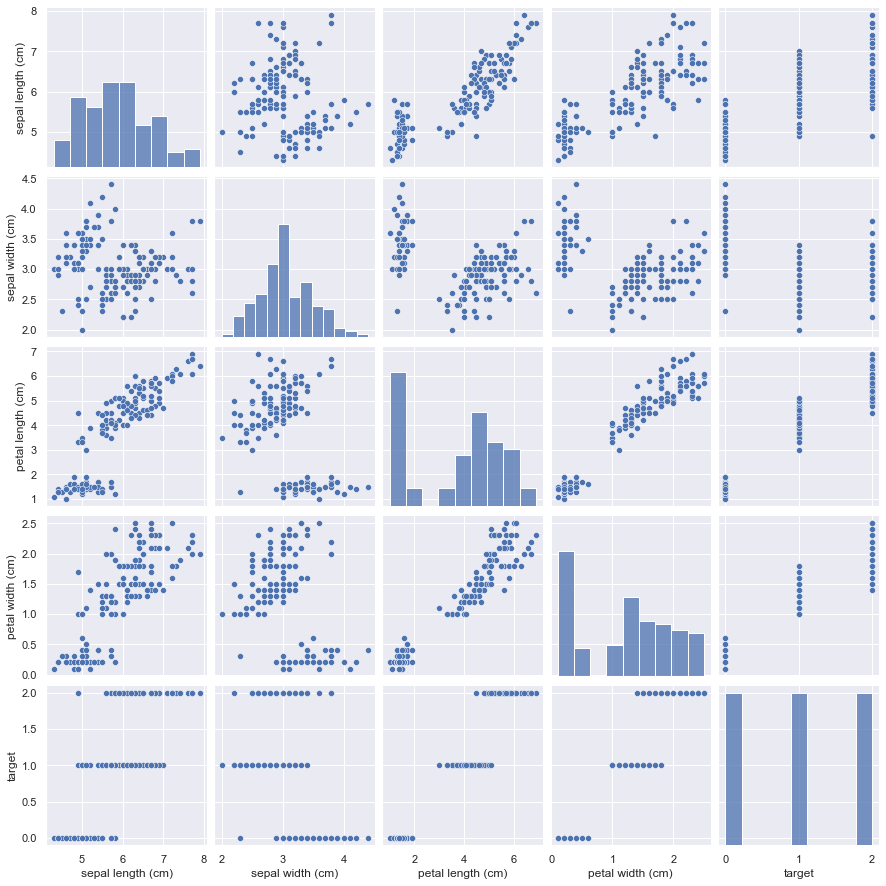

In [73]:
# Getting histograms and correlation scatter plots to see relationships
sns.pairplot(df)

### Train test split and training the decision tree classifier

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 47, test_size = 0.25)

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion = 'entropy')
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

### Making predictions on the test set and getting an accuracy

In [75]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print('Accuracy on train set (DT): ', accuracy_score(y_true=y_train, y_pred=clf.predict(X_train)))
print('Accuracy on test set (DT): ', accuracy_score(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.89      1.00      0.94         8
           2       1.00      0.93      0.97        15

    accuracy                           0.97        38
   macro avg       0.96      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38

Accuracy on train set (DT):  1.0
Accuracy on test set (DT):  0.9736842105263158


### Defining, training, and testing random forest classifier

In [76]:
from sklearn.ensemble import RandomForestClassifier

clf2 = RandomForestClassifier(n_estimators=100)
clf2.fit(X_train,y_train)
y_pred2 = clf2.predict(X_test)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred2))
print('Accuracy on train set (RF): ', accuracy_score(y_true=y_train, y_pred=clf2.predict(X_train)))
print('Accuracy on test set (RF): ', accuracy_score(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.80      1.00      0.89         8
           2       1.00      0.87      0.93        15

    accuracy                           0.95        38
   macro avg       0.93      0.96      0.94        38
weighted avg       0.96      0.95      0.95        38

Accuracy on train set (RF):  1.0
Accuracy on test set (RF):  0.9736842105263158


### Visualizing the decision tree

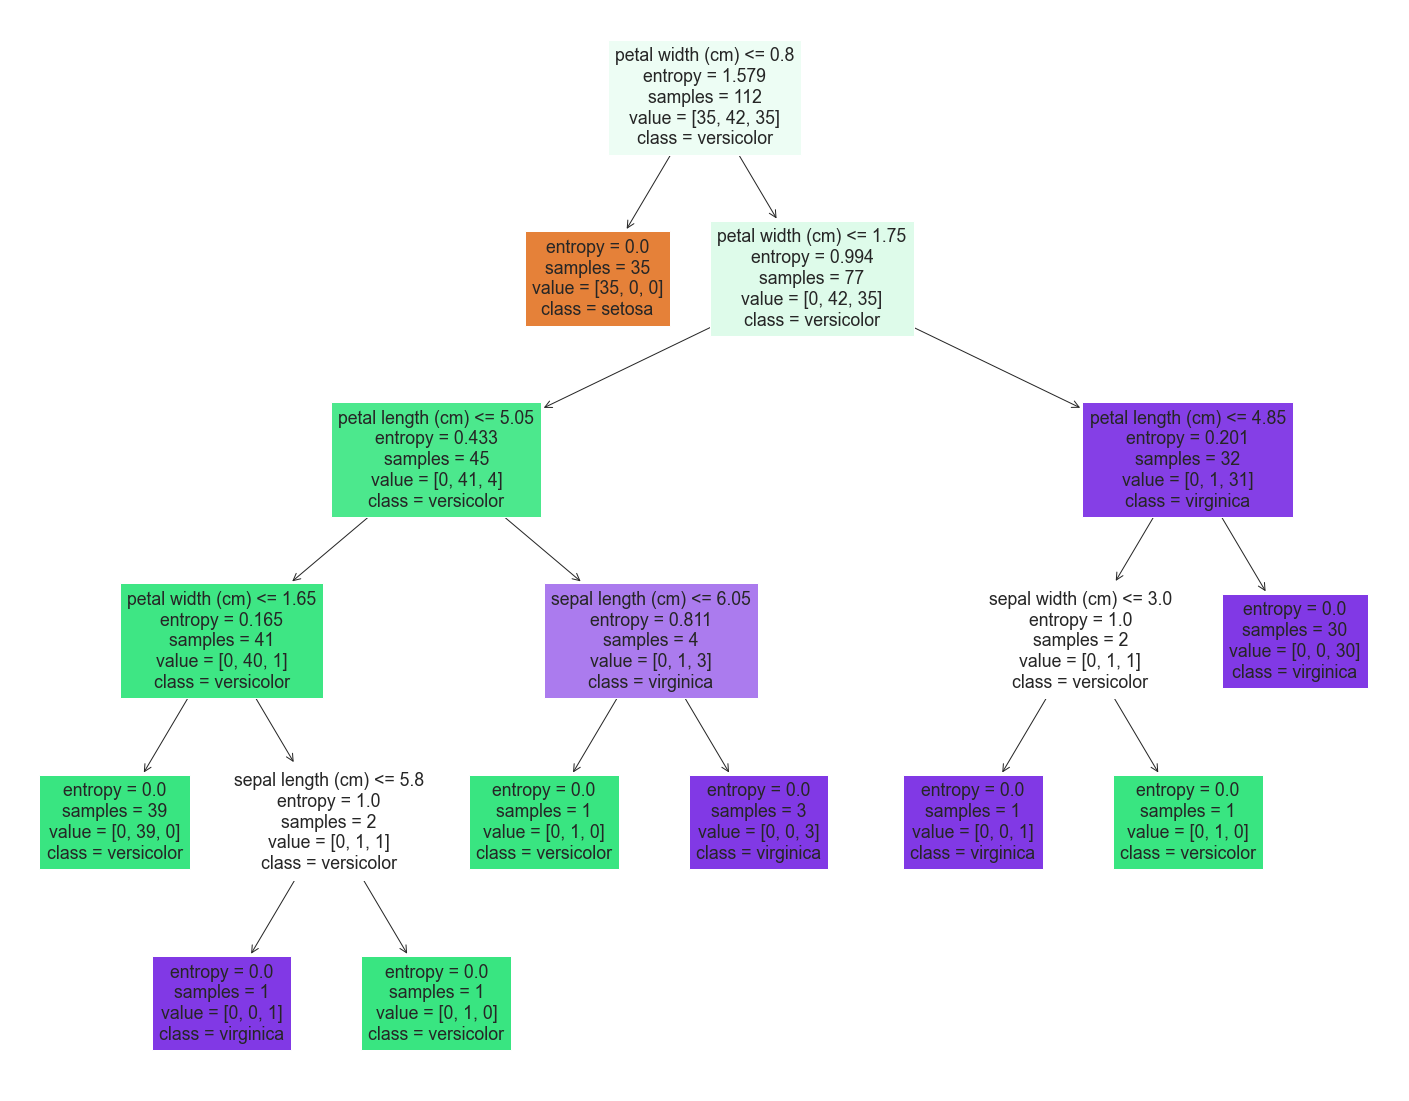

In [77]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=data.feature_names,  
                   class_names=data.target_names,
                   filled=True)

## Example

In [79]:
#numpy and pandas initialization
import numpy as np
import pandas as pd

PlayTennis = pd.read_csv("input/ml-tennis.csv")
PlayTennis.head()

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes


It is easy to implement Decision Tree with numerical values. We can convert all the non numerical values into numerical values using [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

* Lets split the training data and its coresponding prediction values.
* y - holds all the decisions.
* X - holds the training data.

In [80]:
from sklearn.preprocessing import LabelEncoder
Le = LabelEncoder()

PlayTennis['outlook'] = Le.fit_transform(PlayTennis['outlook'])
PlayTennis['temp'] = Le.fit_transform(PlayTennis['temp'])
PlayTennis['humidity'] = Le.fit_transform(PlayTennis['humidity'])
PlayTennis['windy'] = Le.fit_transform(PlayTennis['windy'])
PlayTennis['play'] = Le.fit_transform(PlayTennis['play'])
PlayTennis

,outlook,temp,humidity,windy,play
0,2,1,0,0,0
1,2,1,0,1,0
2,0,1,0,0,1
3,1,2,0,0,1
4,1,0,1,0,1
5,1,0,1,1,0
6,0,0,1,1,1
7,2,2,0,0,0
8,2,0,1,0,1
9,1,2,1,0,1


In [81]:
y = PlayTennis['play']
X = PlayTennis.drop(['play'],axis=1)

In [82]:
# Fitting the model
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion = 'entropy')
clf = clf.fit(X, y)

[Text(0.4, 0.9, 'X[0] <= 0.5\nentropy = 0.94\nsamples = 14\nvalue = [5, 9]'),
 Text(0.3, 0.7, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.5, 0.7, 'X[2] <= 0.5\nentropy = 1.0\nsamples = 10\nvalue = [5, 5]'),
 Text(0.3, 0.5, 'X[0] <= 1.5\nentropy = 0.722\nsamples = 5\nvalue = [4, 1]'),
 Text(0.2, 0.3, 'X[3] <= 0.5\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(0.1, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.3, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.4, 0.3, 'entropy = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.7, 0.5, 'X[3] <= 0.5\nentropy = 0.722\nsamples = 5\nvalue = [1, 4]'),
 Text(0.6, 0.3, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.8, 0.3, 'X[0] <= 1.5\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(0.7, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.9, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]')]

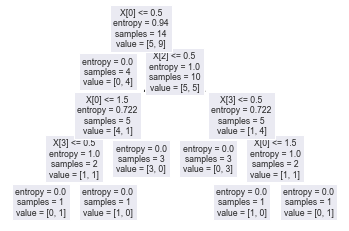

In [83]:
# We can visualize the tree using tree.plot_tree
tree.plot_tree(clf)

## Example: Decision Trees and Random Forests With Python

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('input/ml-kyphosis.csv')
df.head()

,Kyphosis,Age,Number,Start
0,absent,71,3,5
1,absent,158,3,14
2,present,128,4,5
3,absent,2,5,1
4,absent,1,4,15


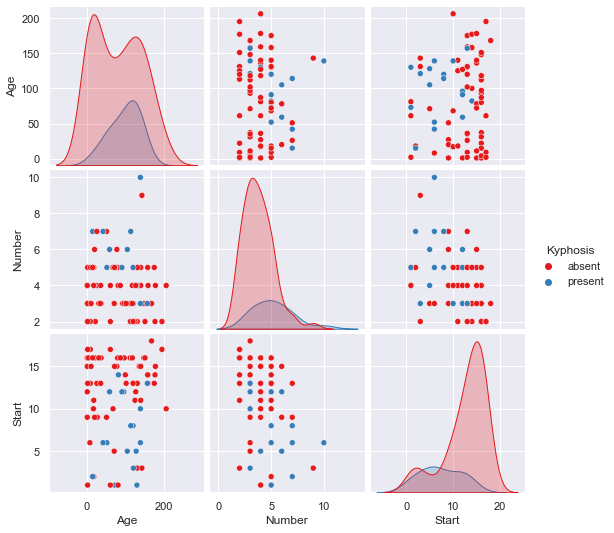

In [85]:
sns.pairplot(df,hue='Kyphosis',palette='Set1')

## Train Test Split & Decision Trees

Let's split up the data into a training set and a test set!

In [86]:
from sklearn.model_selection import train_test_split

X = df.drop('Kyphosis',axis=1)
y = df['Kyphosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [87]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

## Rediction and Evaluation 

Let's evaluate our decision tree.

In [88]:
from sklearn.metrics import classification_report,confusion_matrix

predictions = dtree.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

      absent       0.91      1.00      0.95        20
     present       1.00      0.60      0.75         5

    accuracy                           0.92        25
   macro avg       0.95      0.80      0.85        25
weighted avg       0.93      0.92      0.91        25



In [89]:
print(confusion_matrix(y_test,predictions))

[[20  0]
 [ 2  3]]


## Random Forests

Now let's compare the decision tree model to a random forest.

In [90]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [91]:
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,rfc_pred))

[[20  0]
 [ 4  1]]


In [92]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

      absent       0.83      1.00      0.91        20
     present       1.00      0.20      0.33         5

    accuracy                           0.84        25
   macro avg       0.92      0.60      0.62        25
weighted avg       0.87      0.84      0.79        25



# Example

In [94]:
# Decision Tree Classification

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('input/ml-Ads.csv')
X = dataset.iloc[:, [2, 3]].values
y = dataset.iloc[:, 4].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[62,  6],
       [ 3, 29]])

In [96]:
# Decision Tree Regression

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# Importing the dataset
dataset = pd.read_csv('input/ml-salaries.csv')
X = dataset.iloc[:, 1:2].values
y = dataset.iloc[:, 2].values

# Splitting the dataset into the Training set and Test set
"""from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)"""

# Feature Scaling
"""from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)"""

# Fitting Decision Tree Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X, y)

# Predicting a new result
y_pred=regressor.predict([[6.5]])
y_pred

array([150000.])